In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv(r"/content/data.csv")
df.head()

,x,y
0,-0.250920,2.574699
1,0.901429,101.050273
2,0.463988,24.285346
3,0.197317,1.915087
4,-0.687963,-0.357155


In [ ]:
X_train = df[['x']]
Y_train = df[['y']]

x_train, X_val, y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

x_train = torch.tensor(x_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)

X_val = torch.tensor(X_val.values, dtype=torch.float32)
Y_val = torch.tensor(Y_val.values, dtype=torch.float32)

loss_fn = nn.MSELoss()

In [ ]:
def train_one_epoch(model , optimizer , X, Y,Bs=100):
    indexes = np.random.permutation(len(X))
    losses=[]
    for i,batch_start in enumerate(range(0,len(X),Bs)):
        optimizer.zero_grad()

        x = X[batch_start:min(batch_start + Bs, len(X))]
        y = Y[batch_start:min(batch_start + Bs, len(Y))]

        #print("x = ",torch.isnan(x).sum().item(),"len= ",len(x))
        #print("y = ",y)
        y_pred = model(x)
        #print("y_pred = ",torch.isnan(y_pred).sum().item())
        loss = loss_fn(y_pred,y)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        #print("loss = ",loss)

        losses.append(loss.item())

    return losses

In [ ]:
def compute_validation_loss(model, X_val, Y_val, batch_size=100):
    model.eval()  # Set model to evaluation mode (disables dropout, batchnorm updates)
    val_losses = []

    with torch.no_grad():  # Disable gradient computation for validation
        for batch_start in range(0, len(X_val), batch_size):
            x = X_val[batch_start:min(batch_start + batch_size, len(X_val))]
            y = Y_val[batch_start:min(batch_start + batch_size, len(Y_val))]

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            val_losses.append(loss.item())

    model.train()  # Set back to training mode
    return np.mean(val_losses)

In [ ]:
def train(model, optimizer, X_train, Y_train,X_val, Y_val, Bs=100,num_epochs=100, min_delta = 0.001, patience = 5):

    epoch_losses = []
    val_losses = []
    best_loss = float("inf")
    epochs_no_improve = 0

    pbar = tqdm(range(num_epochs))

    for ep in pbar:
        batch_losses = train_one_epoch(model, optimizer,X_train, Y_train, Bs)
        avg_loss = np.mean(batch_losses)
        epoch_losses.append(avg_loss)

        val_loss = compute_validation_loss(model, X_val, Y_val)
        val_losses.append(val_loss)

        pbar.set_description(f"Epoch {ep+1}: Train Loss = {avg_loss:.4f}, Val Loss = {val_loss:.4f}")

        if abs(avg_loss-best_loss) > min_delta :
            best_loss = avg_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1


        if ep>1 :
          if epochs_no_improve >= patience or ((val_losses[-1] > best_loss)) or ((val_losses[-1] > val_losses[-2])):
              print(f"\nEarly stopping at epoch {ep+1}. No improvement for {patience} epochs.")
              break
    return epoch_losses,val_losses


In [ ]:
def print_train_valid_plot(epoch_losses,val_losses):
    plt.plot(epoch_losses, label="Training Loss", color='blue')
    plt.plot(val_losses, label="Validation Loss", color='red', linestyle='dashed')

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
class Model(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_act='relu', n_layers=3, hidden_dim=120):
        super(Model, self).__init__()

        activation_functions = {
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
            'leaky_relu': nn.LeakyReLU(),
            'elu': nn.ELU()
        }
        if hidden_act not in activation_functions:
            raise ValueError(f"Unsupported activation function: {hidden_act}")

        self.hidden_act = activation_functions[hidden_act]

        self.layers = nn.ModuleList()

        prev_dim = input_shape

        for _ in range(n_layers):
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.layers.append(self.hidden_act)
            prev_dim = hidden_dim

        self.output_layer = nn.Linear(hidden_dim, output_shape)



    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

# MLP Model

Epoch 64: Train Loss = 21.8892, Val Loss = 10.8839:  63%|██████▎   | 63/100 [00:08<00:05,  7.21it/s]



Early stopping at epoch 64. No improvement for 5 epochs.


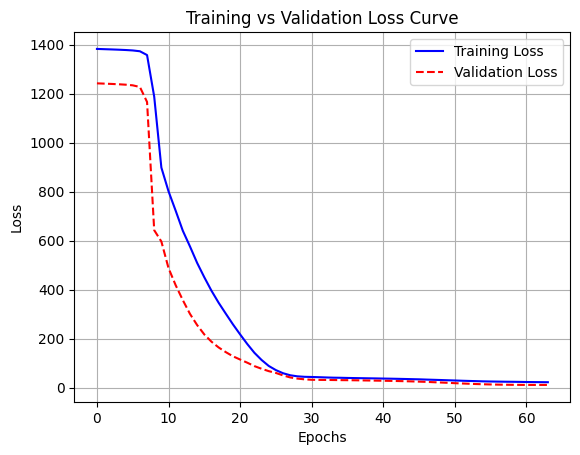

In [ ]:
model1 = Model(input_shape=x_train.shape[1], output_shape=y_train.shape[1] , hidden_act='relu', n_layers=20, hidden_dim=135)
optimizer1 = torch.optim.Adam(model1.parameters() , lr=1e-4)
epoch_losses1,val_losses1 = train(model1, optimizer1, x_train, y_train, X_val, Y_val, Bs=5,num_epochs=100, min_delta = 0.01, patience = 5)
print_train_valid_plot(epoch_losses1,val_losses1)

In [ ]:
def evaluate_model(model, X_test, y_test):
    """Evaluate a regression model with MSE, RMSE, MAE, and a custom accuracy metric."""
    model.eval()

    with torch.no_grad():
        y_pred = model(X_test)  # Get predictions

    # Compute regression metrics
    mse = F.mse_loss(y_pred, y_test).item()
    rmse = mse ** 0.5

    return {"MSE": mse, "RMSE": rmse}

In [ ]:
print("============== Model 1 ================")
print("model1 accuracy = ",evaluate_model(model1,  X_val, Y_val))

============== Model 1 ================
model1 accuracy =  {'MSE': 10.883929252624512, 'RMSE': 3.2990800615663316}


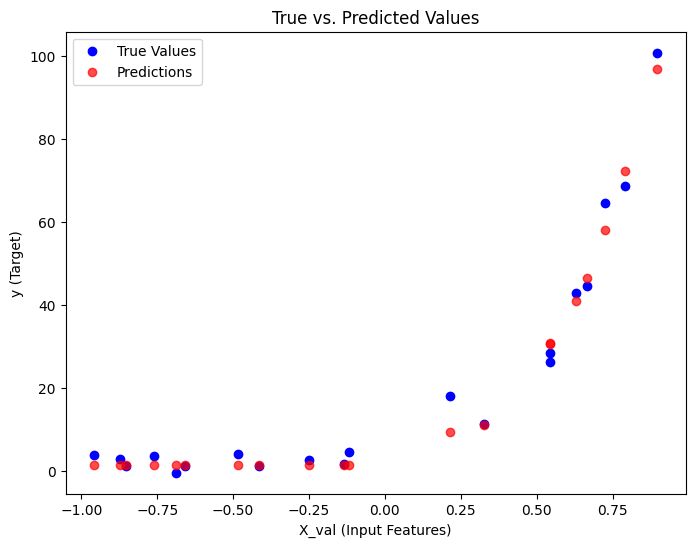

In [ ]:
with torch.no_grad():
      y_pred = model1(X_val)  # Get predictions

# Assuming X_val is a 1D tensor
X_val_np = X_val.numpy().flatten()
y_val_np = Y_val.numpy().flatten()
y_pred_np = y_pred.numpy().flatten()

plt.figure(figsize=(8, 6))
plt.scatter(X_val_np, y_val_np, label="True Values", color="blue")
plt.scatter(X_val_np, y_pred_np, label="Predictions", color="red", alpha=0.7)
plt.xlabel("X_val (Input Features)")
plt.ylabel("y (Target)")
plt.legend()
plt.title("True vs. Predicted Values")
plt.show()


# ML Model

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures

def addPoly(X,polyDegree):
    poly = PolynomialFeatures(polyDegree,include_bias=False)
    X=poly.fit_transform(X)
    return X

X_trainPoly=addPoly(x_train,50)
X_testPoly=addPoly(X_val,50)
scaler=preprocessing.StandardScaler().fit(X_trainPoly)

X_trainPoly=scaler.transform(X_trainPoly)
X_testPoly=scaler.transform(X_testPoly)

In [ ]:
from sklearn import linear_model

model_L2_reg = linear_model.Ridge()
model_L2_reg.fit(X_trainPoly, y_train)

Ridge()

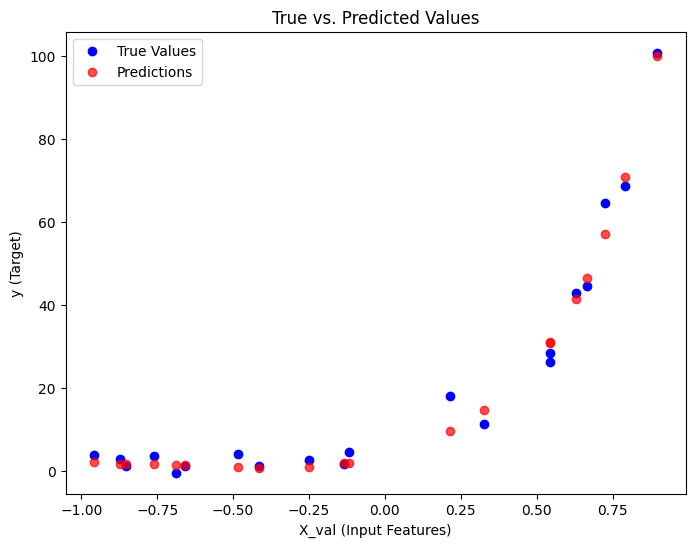

In [ ]:
y_pred_np = model_L2_reg.predict(X_testPoly)
X_val_np = X_val.numpy().flatten()
y_val_np = Y_val.numpy().flatten()
#y_pred_np = Y_pred.numpy().flatten()

plt.figure(figsize=(8, 6))
plt.scatter(X_val_np, y_val_np, label="True Values", color="blue")
plt.scatter(X_val_np, y_pred_np, label="Predictions", color="red", alpha=0.7)
plt.xlabel("X_val (Input Features)")
plt.ylabel("y (Target)")
plt.legend()
plt.title("True vs. Predicted Values")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_val_np,y_pred_np)
rmse = np.sqrt(mean_squared_error(y_val_np,y_pred_np))
print("model1 accuracy = ","MSE", mse, "  ,RMSE", rmse )

model1 accuracy =  MSE 11.96072769165039   ,RMSE 3.4584285002946626


# Conclusion

# MLP ===> RMSE = 3.2
# ML ===> RMSE = 3.4